In [1]:
import sys
sys.path.insert(1, '../model')
import model
import linear_model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter
import optuna
optuna.logging.disable_default_handler()
import pandas as pd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
from scipy.integrate import solve_ivp

In [3]:
raw = pd.read_csv("../data/covid_19_data.csv")

In [4]:
raw

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
42987,42988,06/15/2020,Zacatecas,Mexico,2020-06-16 04:33:09,550.0,58.0,324.0
42988,42989,06/15/2020,Zakarpattia Oblast,Ukraine,2020-06-16 04:33:09,1680.0,42.0,686.0
42989,42990,06/15/2020,Zaporizhia Oblast,Ukraine,2020-06-16 04:33:09,529.0,16.0,335.0
42990,42991,06/15/2020,Zhejiang,Mainland China,2020-06-16 04:33:09,1268.0,1.0,1267.0


In [5]:
data_cols = ["Infected", "Deaths", "Recovered"]
data_cols_all = ["Confirmed", "Infected", "Deaths", "Recovered"]
df = raw.rename({"ObservationDate": "Date", "Province/State": "Province"}, axis=1)
df["Date"] = pd.to_datetime(df["Date"])
df["Country"] = df["Country/Region"]
df.loc[df["Country"] == "Diamond Princess", ["Country", "Province"]] = ["Others", "Diamond Princess"]
df["Infected"] = df["Confirmed"] - df["Deaths"] - df["Recovered"]
df[data_cols_all] = df[data_cols_all].astype(np.int64)
ncov_df_ungrouped = df.loc[:, ["Date", "Country", "Province", *data_cols_all]]
ncov_df_ungrouped.tail()

,Date,Country,Province,Confirmed,Infected,Deaths,Recovered
42987,2020-06-15,Mexico,Zacatecas,550,168,58,324
42988,2020-06-15,Ukraine,Zakarpattia Oblast,1680,952,42,686
42989,2020-06-15,Ukraine,Zaporizhia Oblast,529,178,16,335
42990,2020-06-15,Mainland China,Zhejiang,1268,0,1,1267
42991,2020-06-15,Ukraine,Zhytomyr Oblast,1087,521,19,547


In [6]:
df_germany = ncov_df_ungrouped.loc[ncov_df_ungrouped["Country"] == "Germany", :].groupby("Date").sum()
df_germany['Country'] = 'Germany'
df_germany['Province'] = None
df_germany

,Confirmed,Infected,Deaths,Recovered,Country,Province
Date,,,,,,
2020-01-28,4,4,0,0,Germany,None
2020-01-29,4,4,0,0,Germany,None
2020-01-30,4,4,0,0,Germany,None
2020-01-31,5,5,0,0,Germany,None
2020-02-01,8,8,0,0,Germany,None
...,...,...,...,...,...,...
2020-06-11,186691,6958,8772,170961,Germany,None
2020-06-12,187226,6908,8783,171535,Germany,None
2020-06-13,187267,6504,8793,171970,Germany,None


In [7]:
df_test = pd.read_csv("../data/full-list-total-tests-for-covid-19.csv")
df_test.rename({"Cumulative total tests": "TotalTests"}, axis=1,inplace=True)
df_test["Date"] = pd.to_datetime(df_test["Date"])
df_test_germany = df_test[df_test['Entity'] == 'Germany']
df_test_germany.tail()

,Entity,Code,Date,TotalTests
440,Germany,DEU,2020-03-08,87863
441,Germany,DEU,2020-03-15,215320
442,Germany,DEU,2020-03-22,563939
443,Germany,DEU,2020-03-29,924903
444,Germany,DEU,2020-04-05,1317887


In [13]:
result = pd.merge(df_germany,
                 df_test_germany[['Date','TotalTests']],
                 on='Date',
                 how = 'left')
from numpy import isnan
result.loc[0, ('TotalTests')] = 0 if isnan(result['TotalTests'][0]) else result['TotalTests'][0]
result['TotalTests'].interpolate(method='linear',inplace=True,limit_direction='both')
result['TotalTests'] = result['TotalTests'].astype(int)
border_date = '2020-06-10'
training = result[(result['Date'] > '2020-01-01') & (result['Date'] < border_date)]
test = result[result['Date'] >= border_date]
training

,Date,Confirmed,Infected,Deaths,Recovered,Country,Province,TotalTests
0,2020-01-28,4,4,0,0,Germany,None,0
1,2020-01-29,4,4,0,0,Germany,None,2196
2,2020-01-30,4,4,0,0,Germany,None,4393
3,2020-01-31,5,5,0,0,Germany,None,6589
4,2020-02-01,8,8,0,0,Germany,None,8786
...,...,...,...,...,...,...,...,...
129,2020-06-05,184924,7786,8658,168480,Germany,None,1317887
130,2020-06-06,185450,7819,8673,168958,Germany,None,1317887
131,2020-06-07,185750,7841,8685,169224,Germany,None,1317887
132,2020-06-08,186109,7858,8695,169556,Germany,None,1317887


In [14]:
test

,Date,Confirmed,Infected,Deaths,Recovered,Country,Province,TotalTests
134,2020-06-10,186522,7140,8752,170630,Germany,None,1317887
135,2020-06-11,186691,6958,8772,170961,Germany,None,1317887
136,2020-06-12,187226,6908,8783,171535,Germany,None,1317887
137,2020-06-13,187267,6504,8793,171970,Germany,None,1317887
138,2020-06-14,187518,6628,8801,172089,Germany,None,1317887
139,2020-06-15,187682,6183,8807,172692,Germany,None,1317887


In [15]:
ger_scenario = model.Scenario(training, name="Germany", places=[("Germany", None)])

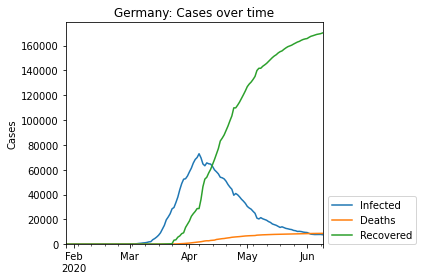

,Date,Confirmed,Infected,Deaths,Recovered
129,2020-06-05,184924,7786,8658,168480
130,2020-06-06,185450,7819,8673,168958
131,2020-06-07,185750,7841,8685,169224
132,2020-06-08,186109,7858,8695,169556
133,2020-06-09,186506,7641,8736,170129


In [16]:
ger_scenario.show_record().tail()

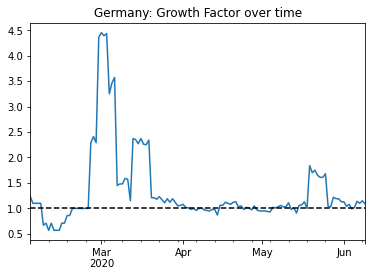

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Germany,2020-06-09,Crossroad,5,0


In [17]:
ger_scenario.growth_factor()

In [18]:
result.loc[result['Date'] == '2020-02-25']

,Date,Confirmed,Infected,Deaths,Recovered,Country,Province,TotalTests
28,2020-02-25,17,3,0,14,Germany,None,61504


In [19]:
result.loc[result['Date'] == '2020-04-13']

,Date,Confirmed,Infected,Deaths,Recovered,Country,Province,TotalTests
76,2020-04-13,130072,62578,3194,64300,Germany,None,1317887


# SIR MODEL

In [39]:
ger_scenario.set_phase(
    start_dates=["20Mar2020", "1Apr2020","13Apr2020"],
    population=82790000
)

,start_date,end_date,population
1st,20Mar2020,31Mar2020,82790000
2nd,1Apr2020,12Apr2020,82790000
3rd,13Apr2020,-,82790000


In [40]:
ger_scenario.estimate(model.SIR)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 8 sec.
	Successfully estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 7 sec.
	Successfully estimated.
Hyperparameter estimation of 3rd phase.
	Estimator was created.
		100 trials finished in 0 min 7 sec.
	Successfully estimated.
Total: 0 min 23 sec.


In [41]:
ger_scenario.show_parameters()

,start_date,end_date,population,tau,rho,sigma,Rt,score,1/beta [day],1/gamma [day]
1st,20Mar2020,31Mar2020,82790000,973,0.101005,0.025763,3.92,0.394784,6,26
2nd,1Apr2020,12Apr2020,82790000,973,0.053928,0.046334,1.16,0.078008,12,14
3rd,13Apr2020,-,82790000,973,0.027641,0.055299,0.50,0.045800,24,12


../model/model.py:762: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


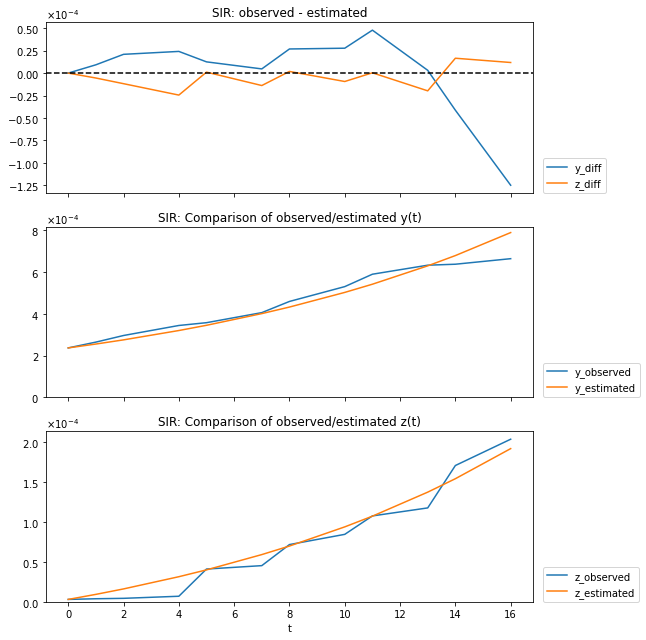

In [42]:
ger_scenario.accuracy_graph(phase_n=1)

../model/model.py:762: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


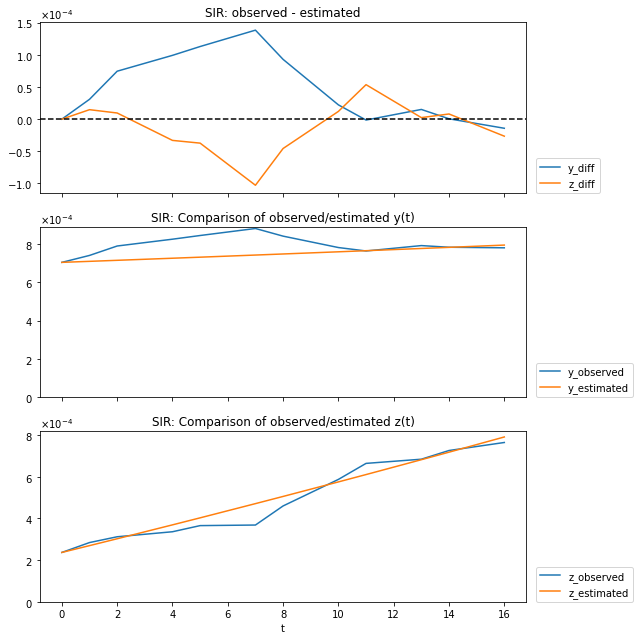

In [43]:
ger_scenario.accuracy_graph(phase_n=2)

../model/model.py:762: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


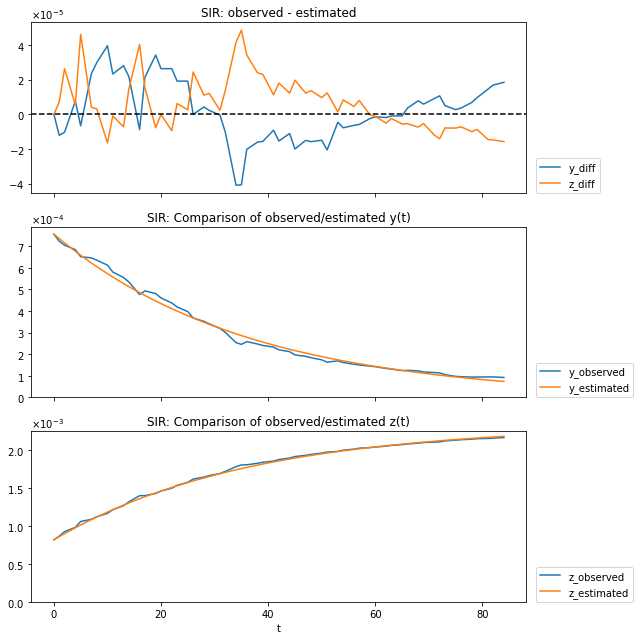

In [44]:
ger_scenario.accuracy_graph(phase_n=3)

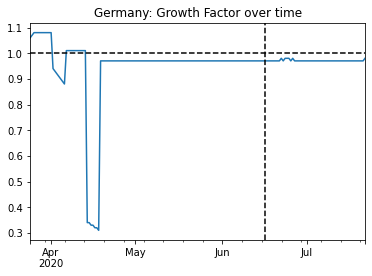

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Germany,2020-07-21 15:39:00,Stopping,0,147


In [45]:
ger_scenario.growth_factor(days_to_predict=100)

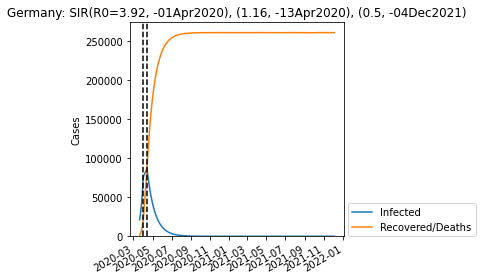

In [46]:
df_sir = ger_scenario.predict(days=600)

In [47]:
df_sir.loc['2020-06-04':'2020-06-09']

,Susceptible,Infected,Recovered/Deaths
Time,,,
2020-06-04 08:29:00,82539758,10257,239983
2020-06-05 00:42:00,82539478,9975,240546
2020-06-05 16:55:00,82539206,9701,241092
2020-06-06 09:08:00,82538941,9434,241623
2020-06-07 01:21:00,82538684,9176,242138
2020-06-07 17:34:00,82538435,8924,242639
2020-06-08 09:47:00,82538192,8680,243126
2020-06-09 02:00:00,82537957,8443,243598
2020-06-09 18:13:00,82537728,8213,244057


# SIRD MODEL

In [48]:
ger_scenario.set_phase(
    start_dates=["20Mar2020", "1Apr2020","13Apr2020"],
    population=82790000
)

,start_date,end_date,population
1st,20Mar2020,31Mar2020,82790000
2nd,1Apr2020,12Apr2020,82790000
3rd,13Apr2020,-,82790000


In [49]:
ger_scenario.estimate(model.SIRD)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 10 sec.
		100 trials finished in 0 min 10 sec.
	Successfully estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 7 sec.
	Successfully estimated.
Hyperparameter estimation of 3rd phase.
	Estimator was created.
		100 trials finished in 0 min 8 sec.
	Successfully estimated.
Total: 0 min 36 sec.


In [50]:
ger_scenario.show_parameters()

,start_date,end_date,population,tau,kappa,rho,sigma,Rt,score,1/alpha2 [day],1/beta [day],1/gamma [day]
1st,20Mar2020,31Mar2020,82790000,724,0.000753,0.072958,0.017474,4.00,0.432941,667,6,28
2nd,1Apr2020,12Apr2020,82790000,724,0.001439,0.038712,0.031920,1.16,0.096934,349,12,15
3rd,13Apr2020,-,82790000,724,0.001943,0.020796,0.039162,0.51,0.055936,258,24,12


../model/model.py:762: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


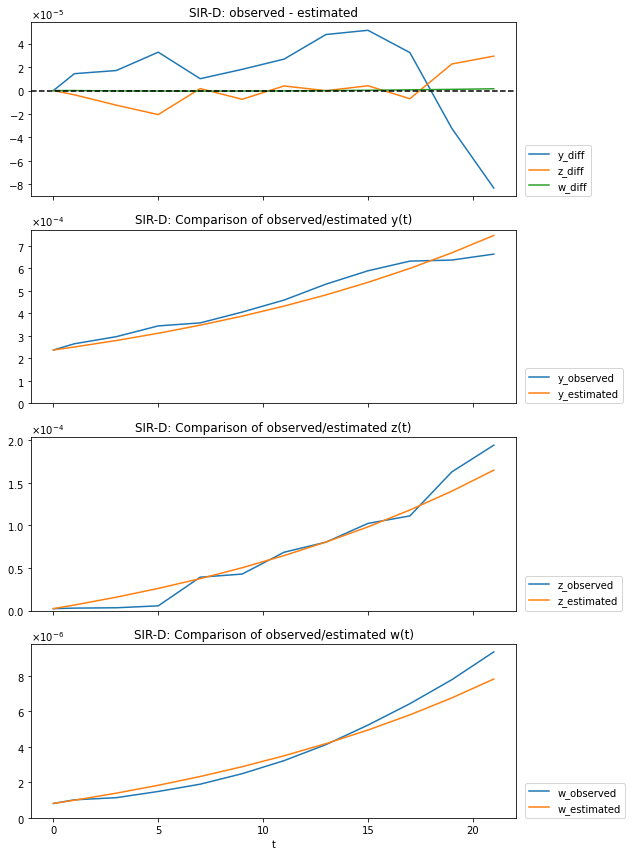

In [51]:
ger_scenario.accuracy_graph(phase_n=1)

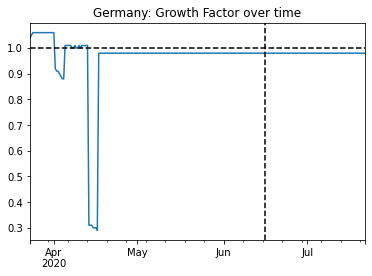

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Germany,2020-07-21 16:24:00,Stopping,0,198


In [52]:
ger_scenario.growth_factor(days_to_predict=100)

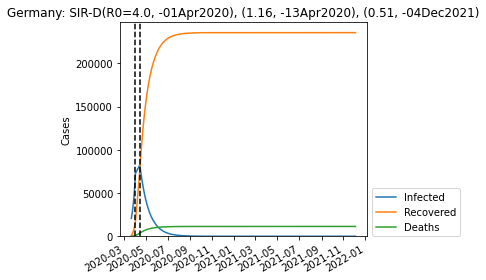

In [53]:
df_sird = ger_scenario.predict(days=600)

In [54]:
df_sird.loc['2020-06-04':'2020-06-10']

,Susceptible,Infected,Recovered,Deaths
Time,,,,
2020-05-02 05:44:00,82581701,38126,162436,7735
2020-05-02 17:48:00,82580914,37353,163923,7808
2020-05-03 05:52:00,82580143,36596,165379,7881
2020-05-03 17:56:00,82579387,35854,166805,7951
2020-05-04 06:00:00,82578647,35128,168202,8021
2020-05-04 18:04:00,82577922,34416,169571,8089
2020-05-05 06:08:00,82577212,33719,170912,8155
2020-05-05 18:12:00,82576516,33036,172225,8220
2020-05-06 06:16:00,82575835,32367,173511,8284


# SIRF MODEL

In [55]:
ger_scenario.estimate(model.SIRF)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 10 sec.
		100 trials finished in 0 min 11 sec.
		100 trials finished in 0 min 13 sec.
		100 trials finished in 0 min 14 sec.
		100 trials finished in 0 min 15 sec.
		100 trials finished in 0 min 16 sec.
	Successfully estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 8 sec.
		100 trials finished in 0 min 9 sec.
	Successfully estimated.
Hyperparameter estimation of 3rd phase.
	Estimator was created.
		100 trials finished in 0 min 8 sec.
		100 trials finished in 0 min 10 sec.
		100 trials finished in 0 min 11 sec.
		100 trials finished in 0 min 11 sec.
		100 trials finished in 0 min 13 sec.
	Successfully estimated.
Total: 2 min 33 sec.


In [56]:
ger_scenario.show_parameters()

,start_date,end_date,population,tau,theta,kappa,rho,sigma,Rt,score,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day]
1st,20Mar2020,31Mar2020,82790000,1301,0.000145,0.001496,0.121976,0.035388,3.31,0.529221,0.000,604,7,25
2nd,1Apr2020,12Apr2020,82790000,1301,0.035374,0.000764,0.059693,0.040561,1.39,0.114604,0.035,1182,15,22
3rd,13Apr2020,-,82790000,1301,0.109700,0.000705,0.028562,0.059882,0.42,0.073949,0.110,1281,31,15


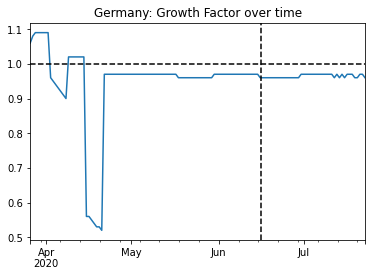

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Germany,2020-07-22 16:18:00,Stopping,0,110


In [57]:
ger_scenario.growth_factor(days_to_predict=100)

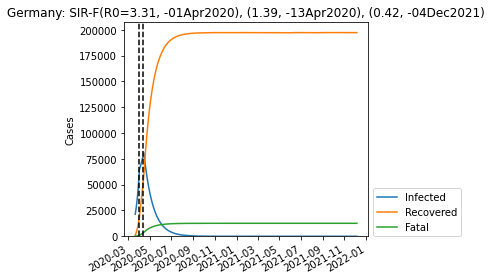

In [58]:
df_seird = ger_scenario.predict(days=600)

In [59]:
df_seird.loc['2020-06-04':'2020-06-10']

,Susceptible,Infected,Recovered,Fatal,Confirmed
Time,,,,,
2020-05-02 08:48:00,82612417,39966,129395,8220,177581
2020-05-03 06:29:00,82611300,38585,131743,8370,178698
2020-05-04 04:10:00,82610221,37252,134010,8515,179777
2020-05-05 01:51:00,82609179,35965,136199,8655,180819
2020-05-05 23:32:00,82608173,34721,138314,8790,181825
2020-05-06 21:13:00,82607200,33520,140357,8921,182798
2020-05-07 18:54:00,82606260,32358,142332,9047,183737
2020-05-08 16:35:00,82605352,31235,144241,9170,184646


# SEWIRF

In [60]:
ger_scenario.estimate(model.SEWIRF)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 12 sec.
		100 trials finished in 0 min 11 sec.
		100 trials finished in 0 min 12 sec.
		100 trials finished in 0 min 14 sec.
		100 trials finished in 0 min 15 sec.
		100 trials finished in 0 min 18 sec.
		100 trials finished in 0 min 21 sec.
		100 trials finished in 0 min 22 sec.
		100 trials finished in 0 min 25 sec.
		100 trials finished in 0 min 24 sec.
		100 trials finished in 0 min 23 sec.
	Estimator will be replaced because it is incapable of improvement.
	Estimator was created.
		100 trials finished in 0 min 10 sec.
		100 trials finished in 0 min 11 sec.
		100 trials finished in 0 min 14 sec.
		100 trials finished in 0 min 14 sec.
		100 trials finished in 0 min 16 sec.
	Successfully estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 9 sec.
		100 trials finished in 0 min 11 sec.
		100 trials finished in 0 min 11 sec.
		100 trials fi

In [61]:
ger_scenario.show_parameters()

,start_date,end_date,population,tau,theta,kappa,rho1,rho2,rho3,sigma,Rt,score,alpha1 [-],1/alpha2 [day],1/beta1 [day],1/beta2 [day],1/beta3 [day],1/gamma [day]
1st,20Mar2020,31Mar2020,82790000,1117,0.000122,0.001039,0.399166,0.144605,0.832246,0.029653,13.00,0.469379,0.000,746,1,5,0,26
2nd,1Apr2020,12Apr2020,82790000,1117,0.034710,0.000330,0.085586,0.915219,0.380867,0.045237,1.81,0.147855,0.035,2351,9,0,2,17
3rd,13Apr2020,-,82790000,1117,0.063153,0.000418,0.030291,0.952860,0.318576,0.067721,0.42,0.183539,0.063,1857,25,0,2,11


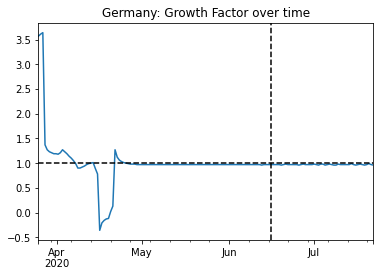

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Germany,2020-07-22 02:40:00,Stopping,0,113


In [62]:
ger_scenario.growth_factor(days_to_predict=100)

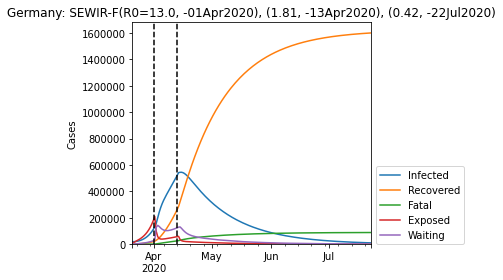

In [63]:
df_sewirf = ger_scenario.predict(days=100)

In [64]:
df_sewirf.loc['2020-06-04':'2020-06-10']

,Susceptible,Infected,Recovered,Fatal,Exposed,Waiting,Confirmed
Time,,,,,,,
2020-05-02 10:32:00,81388768,298679,992694,63003,10935,35918,1354376
2020-05-03 05:09:00,81378965,289174,1012601,63835,10435,34987,1365610
2020-05-03 23:46:00,81369466,280065,1031873,64647,10165,33781,1376585
2020-05-04 18:23:00,81360269,271253,1050535,65434,9928,32578,1387222
2020-05-05 13:00:00,81351369,262621,1068613,66190,9497,31706,1397424
2020-05-06 07:37:00,81342749,254321,1086116,66925,9209,30678,1407362
2020-05-07 02:14:00,81334400,246311,1103062,67639,8994,29590,1417012
2020-05-07 20:51:00,81326321,238476,1119478,68326,8621,28775,1426280
2020-05-08 15:28:00,81318497,230922,1135372,68993,8333,27880,1435287


# comparison 

In [80]:
def getValuesVector(df, label):
    d = ''
    arr = []
    for index, row in df.loc['2020-06-10':'2020-06-15'].iterrows():
        ind = str(index).split(" ")[0]
        if (d == ind):
            arr[-1] = round((arr[-1] + row[label]) / 2, 0)
        else:
            arr.append(row[label])
        d = ind
    return arr

def getComparison(df_sewirf, df_seird, df_sird, df_sir, label):
    fit = linear_model.fitFuntion(training, label)
    x, y = linear_model.getDataSet(result, label)
    func = fit['function']
    popt = fit['popt']
     
    df = pd.DataFrame()
    df["sewirf_" + label] = getValuesVector(df_sewirf.loc['2020-06-10':'2020-06-15'], label)
    df["sirf_" + label] = getValuesVector(df_seird.loc['2020-06-10':'2020-06-15'], label)
    df["sird_" + label] = getValuesVector(df_sird.loc['2020-06-10':'2020-06-15'], label)
    df["sir_" + label] = getValuesVector(df_sir.loc['2020-06-10':'2020-06-15'], label)
    df["function_fit_" + label] = func(x, *popt)[-7:-1]
    df[label] = list(test[label])
    
    squareError = pd.DataFrame()
    squareError["sewirf_" + label] = np.square(list(df["sewirf_" + label] - df[label]))
    squareError["sirf_" + label] = np.square(list(df["sirf_" + label] - df[label]))
    squareError["sird_" + label] = np.square(list(df["sird_" + label] - df[label]))
    squareError["sir_" + label] = np.square(list(df["sir_" + label] - df[label]))
    squareError["function_fit_" + label] = np.square(list(df["function_fit_" + label] - df[label]))

    return (df, squareError)

## Infected

In [81]:
comp, squareError = getComparison(df_sewirf, df_seird, df_sird, df_sir, "Infected")

In [82]:
comp

,sewirf_Infected,sirf_Infected,sird_Infected,sir_Infected,function_fit_Infected,Infected
0,58740.0,8794.0,7715.0,7989.0,5812.058738,7140
1,55911.0,8487.0,7410.0,7666.0,6076.989103,6958
2,54216.0,8047.0,7118.0,7356.0,6429.765809,6908
3,52489.0,7628.0,6838.0,7060.0,6873.009387,6504
4,49974.0,7362.0,6570.0,6775.0,7409.340373,6628
5,47659.0,7106.0,6312.0,6504.0,8041.379298,6183


In [83]:
squareError

,sewirf_Infected,sirf_Infected,sird_Infected,sir_Infected,function_fit_Infected
0,2.662560e+09,2735716.0,330625.0,720801.0,1.763428e+06
1,2.396396e+09,2337841.0,204304.0,501264.0,7.761802e+05
2,2.238047e+09,1297321.0,44100.0,200704.0,2.287079e+05
3,2.114620e+09,1263376.0,111556.0,309136.0,1.361679e+05
4,1.878876e+09,538756.0,3364.0,21609.0,6.104928e+05
5,1.720259e+09,851929.0,16641.0,103041.0,3.453574e+06


In [84]:
1/7 * squareError.sum()

sewirf_Infected          1.858680e+09
sirf_Infected            1.289277e+06
sird_Infected            1.015129e+05
sir_Infected             2.652221e+05
function_fit_Infected    9.955072e+05
dtype: float64

PREDICTING IN PHASES

TRYING TO INCLUDE TESTS